# Human Activity Recognition
### Detecting the type of motion based on acceleration signals


In [67]:
# Set up notebook headers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import datetime, timedelta

from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.transformers import FeatureSelector

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Data Collection
I have recorded linear acceleration data for two different activities (**walking** and **running**) - each for at least two minutes. This was done using the Physics Toolbox Sensor Toolbox app. These activities were conducted on the same day and circuit to ensure a fair comparison.

#### Loading Raw Data
Read in CSV files containing linear acceleration in the x, y, and z-planes.

In [68]:
# Read in both sets of data
walk = pd.read_csv("Walk.csv", header = 0, parse_dates = True, index_col = 0, names = ["time", "ax", "ay", "az", "aT"])
walk = walk.groupby('time').mean()
run = pd.read_csv("Run.csv", header = 0, parse_dates = True, index_col = 0, names = ["time", "ax", "ay", "az", "aT"])
run = run.groupby('time').mean()

In [69]:
walk.head()

,ax,ay,az,aT
time,,,,
2021-09-05 18:08:58:7560,-0.5127,0.0841,-0.5346,0.745
2021-09-05 18:08:58:7630,-0.3637,0.0731,-0.5656,0.676
2021-09-05 18:08:58:7740,-0.1706,0.0675,-0.4495,0.486
2021-09-05 18:08:58:7830,0.1049,-0.0487,-0.3031,0.324
2021-09-05 18:08:58:7940,0.3817,-0.0201,-0.2086,0.435


In [70]:
run.head()

,ax,ay,az,aT
time,,,,
2021-09-05 16:21:00:7800,0.3121,-0.4226,0.3521,0.632
2021-09-05 16:21:00:7880,0.4055,-0.4540,0.4430,0.753
2021-09-05 16:21:00:8000,0.4227,-0.4234,0.5280,0.798
2021-09-05 16:21:00:8090,0.4413,-0.3453,0.5187,0.764
2021-09-05 16:21:00:8200,0.4911,-0.2580,0.4240,0.698


#### Visualise Raw Data
View acceleration signals to see if anything stands out.

Text(0, 0.5, 'Linear Acceleration (m^2/s)')

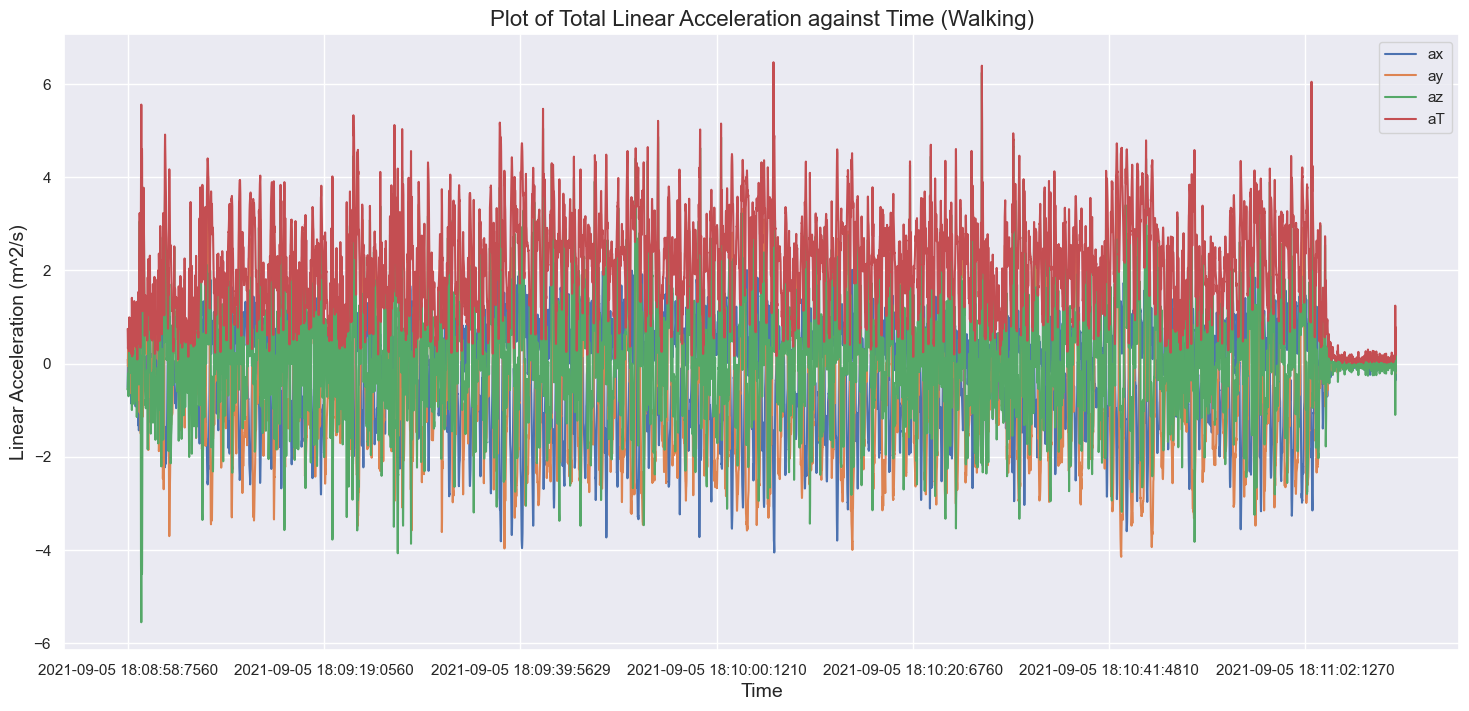

In [71]:
# Plot linear accelerations over time for each activity
ax = walk.plot(figsize = (18, 8))
ax.set_title("Plot of Total Linear Acceleration against Time (Walking)", fontsize = 16)
ax.set_xlabel("Time", fontsize = 14)
ax.set_ylabel("Linear Acceleration (m^2/s)", fontsize = 14)

Text(0, 0.5, 'Linear Acceleration (m^2/s)')

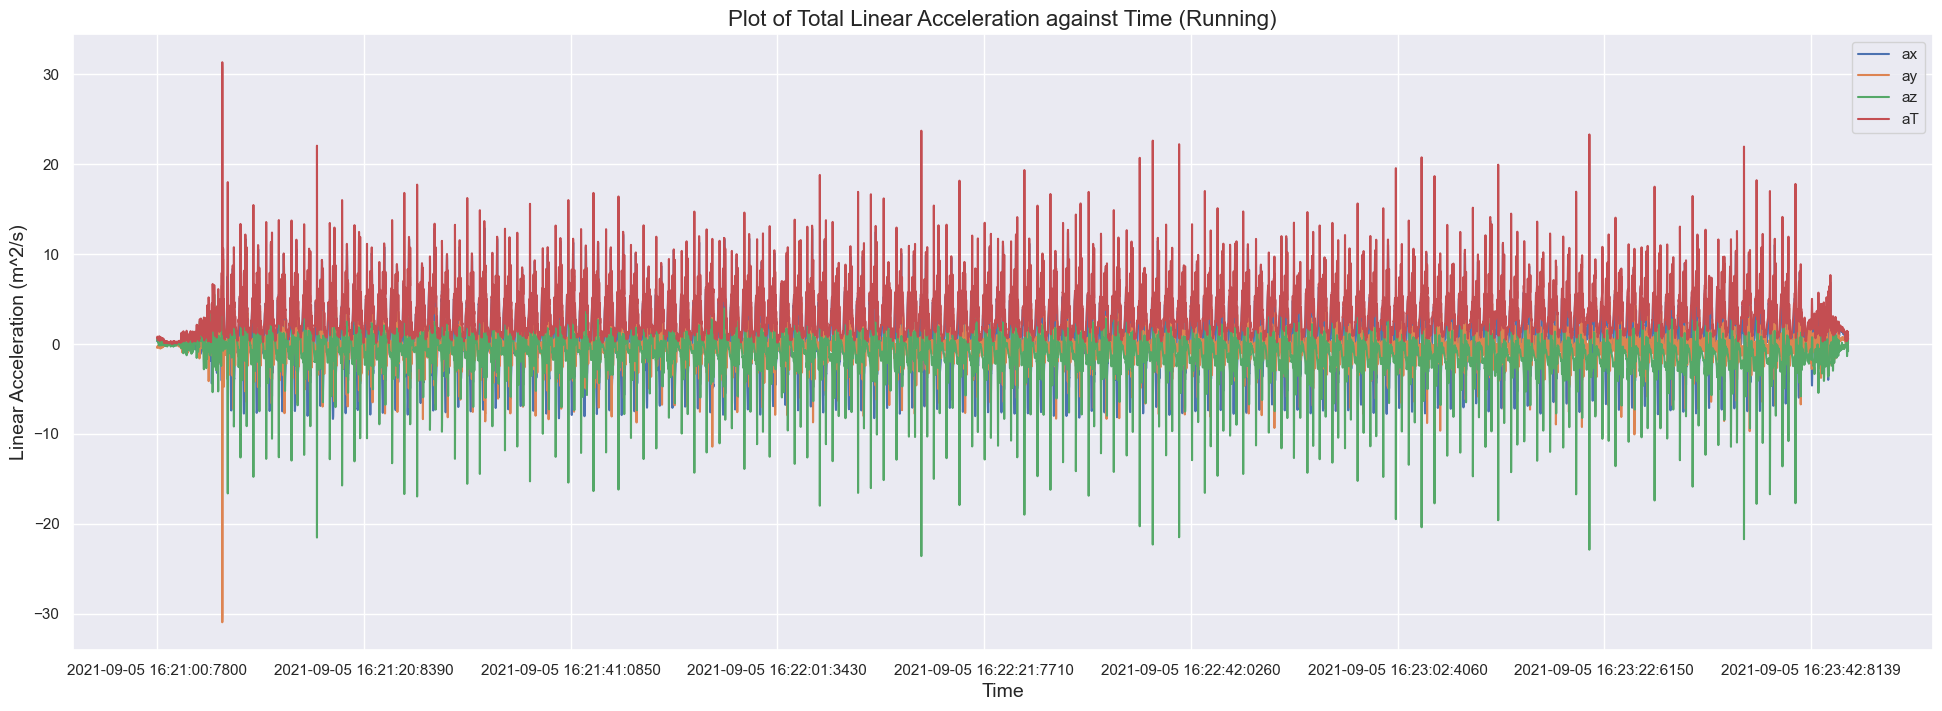

In [72]:
ax = run.plot(figsize = (24, 8))
ax.set_title("Plot of Total Linear Acceleration against Time (Running)", fontsize = 16)
ax.set_xlabel("Time", fontsize = 14)
ax.set_ylabel("Linear Acceleration (m^2/s)", fontsize = 14)

It is evident that total linear acceleration is greater on average when running compared to walking. The latter plot contains more data points as it was recorded over a longer time period. The number of peaks and troughs are also a lot higher due to the higher frequency of motion.

There are clear transition periods at the start and end of each plot, as displayed by the sharp increase and decrease in acceleration, respectively. This is more evident in the latter plot as the magnitude is a lot greater than the former.

For the walking plot, the transition period at the start is about 1s, whilst at the end it is 8s. Similarly for the running plot, it is 6s at the start and 4s at the end.

#### Preprocess Data
Create additional columns for analysis and remove unnecessary data.

In [73]:
# Add new column for delta times in each dataset
walk_t = pd.to_datetime(walk.index, format = "%Y-%m-%d %H:%M:%S:%f")
walk["delta_t"] = walk_t - walk_t[0]

run_t = pd.to_datetime(run.index, format = "%Y-%m-%d %H:%M:%S:%f")
run["delta_t"] = run_t - run_t[0]

In [74]:
walk.head()

,ax,ay,az,aT,delta_t
time,,,,,
2021-09-05 18:08:58:7560,-0.5127,0.0841,-0.5346,0.745,0 days 00:00:00
2021-09-05 18:08:58:7630,-0.3637,0.0731,-0.5656,0.676,0 days 00:00:00.007000
2021-09-05 18:08:58:7740,-0.1706,0.0675,-0.4495,0.486,0 days 00:00:00.018000
2021-09-05 18:08:58:7830,0.1049,-0.0487,-0.3031,0.324,0 days 00:00:00.027000
2021-09-05 18:08:58:7940,0.3817,-0.0201,-0.2086,0.435,0 days 00:00:00.038000


In [75]:
run.head()

,ax,ay,az,aT,delta_t
time,,,,,
2021-09-05 16:21:00:7800,0.3121,-0.4226,0.3521,0.632,0 days 00:00:00
2021-09-05 16:21:00:7880,0.4055,-0.4540,0.4430,0.753,0 days 00:00:00.008000
2021-09-05 16:21:00:8000,0.4227,-0.4234,0.5280,0.798,0 days 00:00:00.020000
2021-09-05 16:21:00:8090,0.4413,-0.3453,0.5187,0.764,0 days 00:00:00.029000
2021-09-05 16:21:00:8200,0.4911,-0.2580,0.4240,0.698,0 days 00:00:00.040000


In [76]:
# Remove transition periods based on visualisations above
start_w = 1
end_w = (walk.iloc[-1]["delta_t"]).total_seconds() - 8
walk = walk[(timedelta(seconds = start_w) < walk.delta_t) & (walk.delta_t < timedelta(seconds = end_w))]

In [77]:
start_r = 6
end_r = (run.iloc[-1]["delta_t"]).total_seconds() - 4
run = run[(timedelta(seconds = start_r) < run.delta_t) & (run.delta_t < timedelta(seconds = end_r))]

Text(0, 0.5, 'Linear Acceleration (m^2/s)')

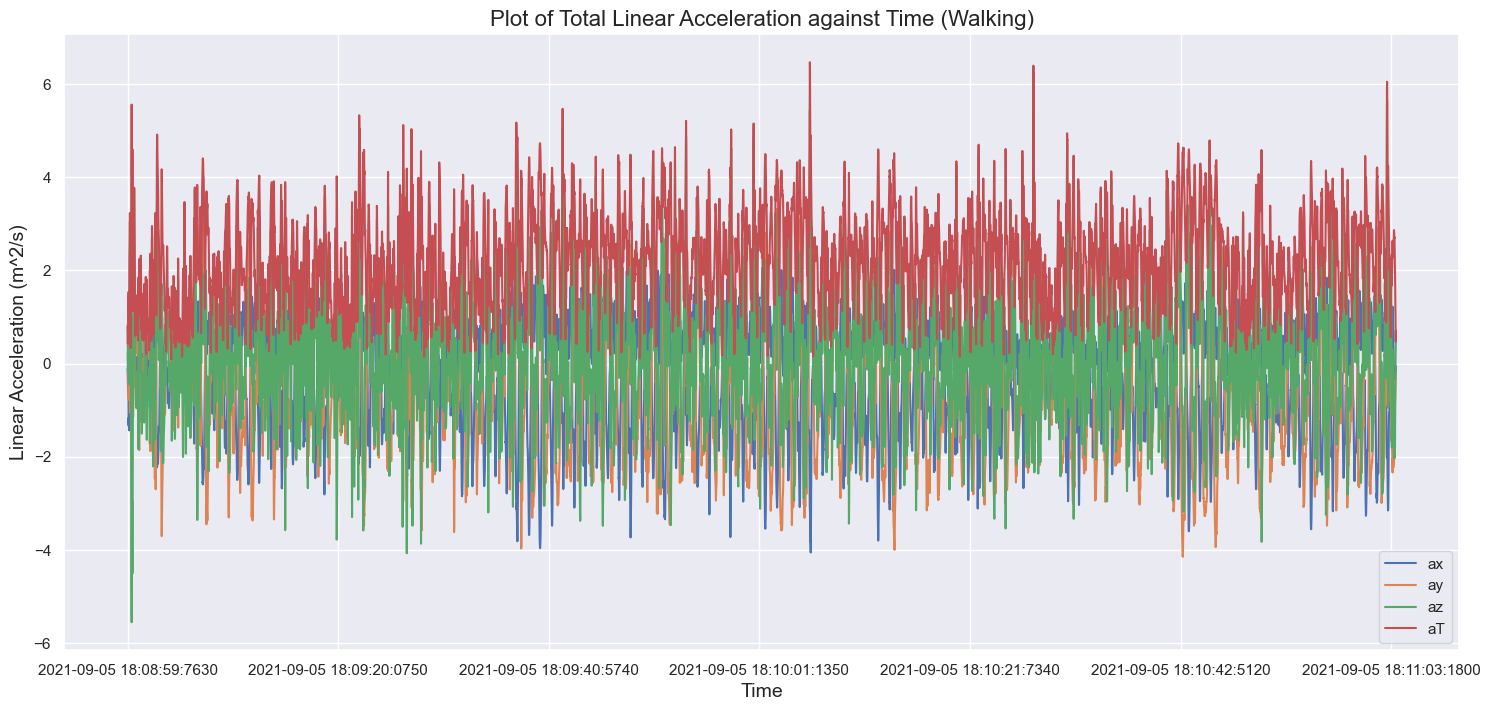

In [78]:
# Visualise signals again
ax = walk.iloc[:, :4].plot(figsize = (18, 8))
ax.set_title("Plot of Total Linear Acceleration against Time (Walking)", fontsize = 16)
ax.set_xlabel("Time", fontsize = 14)
ax.set_ylabel("Linear Acceleration (m^2/s)", fontsize = 14)

Text(0, 0.5, 'Linear Acceleration (m^2/s)')

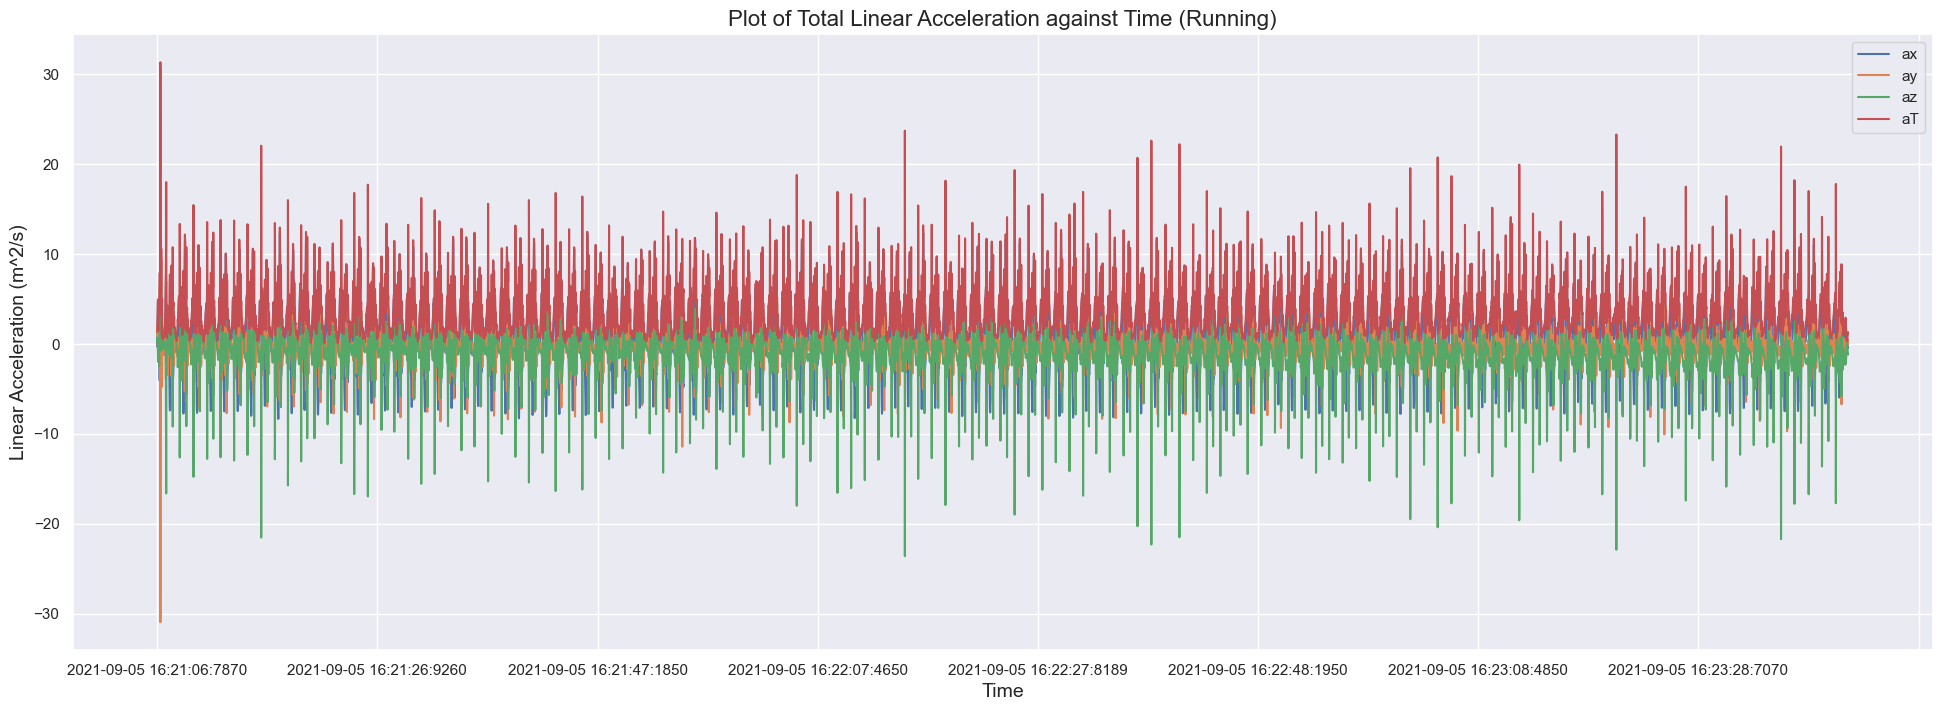

In [79]:
ax = run.iloc[:, :4].plot(figsize = (24, 8))
ax.set_title("Plot of Total Linear Acceleration against Time (Running)", fontsize = 16)
ax.set_xlabel("Time", fontsize = 14)
ax.set_ylabel("Linear Acceleration (m^2/s)", fontsize = 14)

In [80]:
# Find length of remaining signals 
length_w = walk.iloc[-1]["delta_t"] - walk.iloc[0]["delta_t"]
print('Walking time:', length_w.total_seconds(), 'seconds')

Walking time: 123.89 seconds


In [81]:
length_r = run.iloc[-1]["delta_t"] - run.iloc[0]["delta_t"]
print('Running time:', length_r.total_seconds(), 'seconds')

Running time: 155.639 seconds


#### Feature Extraction
Extract meaningful features from processed data to predict type of motion.

In [82]:
# Create new column for sampling
walk_wind = np.asarray(np.floor(walk.reset_index().index / 100).values, np.int64)
walk["window_idx"] = ["w{:03}".format(i) for i in walk_wind]

run_wind = np.asarray(np.floor(run.reset_index().index / 100).values, np.int64)
run["window_idx"] = ["r{:03}".format(i) for i in run_wind]

# Find shape of each dataset
print("Shape of walking dataframe:", walk.shape)

Shape of walking dataframe: (12045, 6)


C:\Users\rohit\AppData\Local\Temp\ipykernel_14524\2274809768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walk["window_idx"] = ["w{:03}".format(i) for i in walk_wind]
C:\Users\rohit\AppData\Local\Temp\ipykernel_14524\2274809768.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run["window_idx"] = ["r{:03}".format(i) for i in run_wind]


In [83]:
print("Shape of running dataframe:", run.shape)

Shape of running dataframe: (15361, 6)


In [84]:
# Concatenate the datasets
complete = pd.concat([walk, run])

# Find new shape of combined dataset
print("Shape of concatenated dataframe:", complete.shape)

Shape of concatenated dataframe: (27406, 6)


In [85]:
# Find unique values of window_idx
print("Number of unique values in column window_idx:", len((complete["window_idx"]).unique()))

Number of unique values in column window_idx: 275


In [86]:
# Introduce new sorting column for ID's
complete["time_parse"] = [datetime.strptime(i, "%Y-%m-%d %H:%M:%S:%f") for i in complete.index.values]
complete["sort"] = complete["time_parse"] + complete["delta_t"]
complete["delta_t"] = [i.total_seconds() for i in complete["delta_t"]]
complete = complete.drop(["time_parse"], axis = 1)

In [87]:
# Characterise activity windows
minimal_fc = MinimalFCParameters()
X = extract_features(complete, column_id = "window_idx", column_sort = "sort", default_fc_parameters = minimal_fc)

Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Used MinimalFCParameters instead of the default parameters as it returned better model results and generates clear distinctions in the pairs plot below.

In [88]:
# Check for and remove columns with NaNs
X = X.dropna(axis = 1)

# Find size of feature matrix
print("Dimensions of feature matrix:", X.shape)
print(X.shape[1], "features have been extracted")

Dimensions of feature matrix: (275, 50)
50 features have been extracted


#### Create Activity Recognition Model
Reduce the number of features generated above to create a model for human activity recognition and evaluate its performance.

In [89]:
# Add binary classification targets to the dataset (walk = True, run = False)
target = [i[0] == 'w' for i in X.index.values]
target = pd.Series(target, index = X.index.values)

# Reduce number of features
reg_select = FeatureSelector()
select = FeatureSelector()
select.fit(X, target)
Xselected = select.transform(X)

# Find the five features with the smallest p-values
features = select.relevant_features[:5]
features

['aT__absolute_maximum',
 'aT__maximum',
 'ax__maximum',
 'aT__standard_deviation',
 'aT__variance']

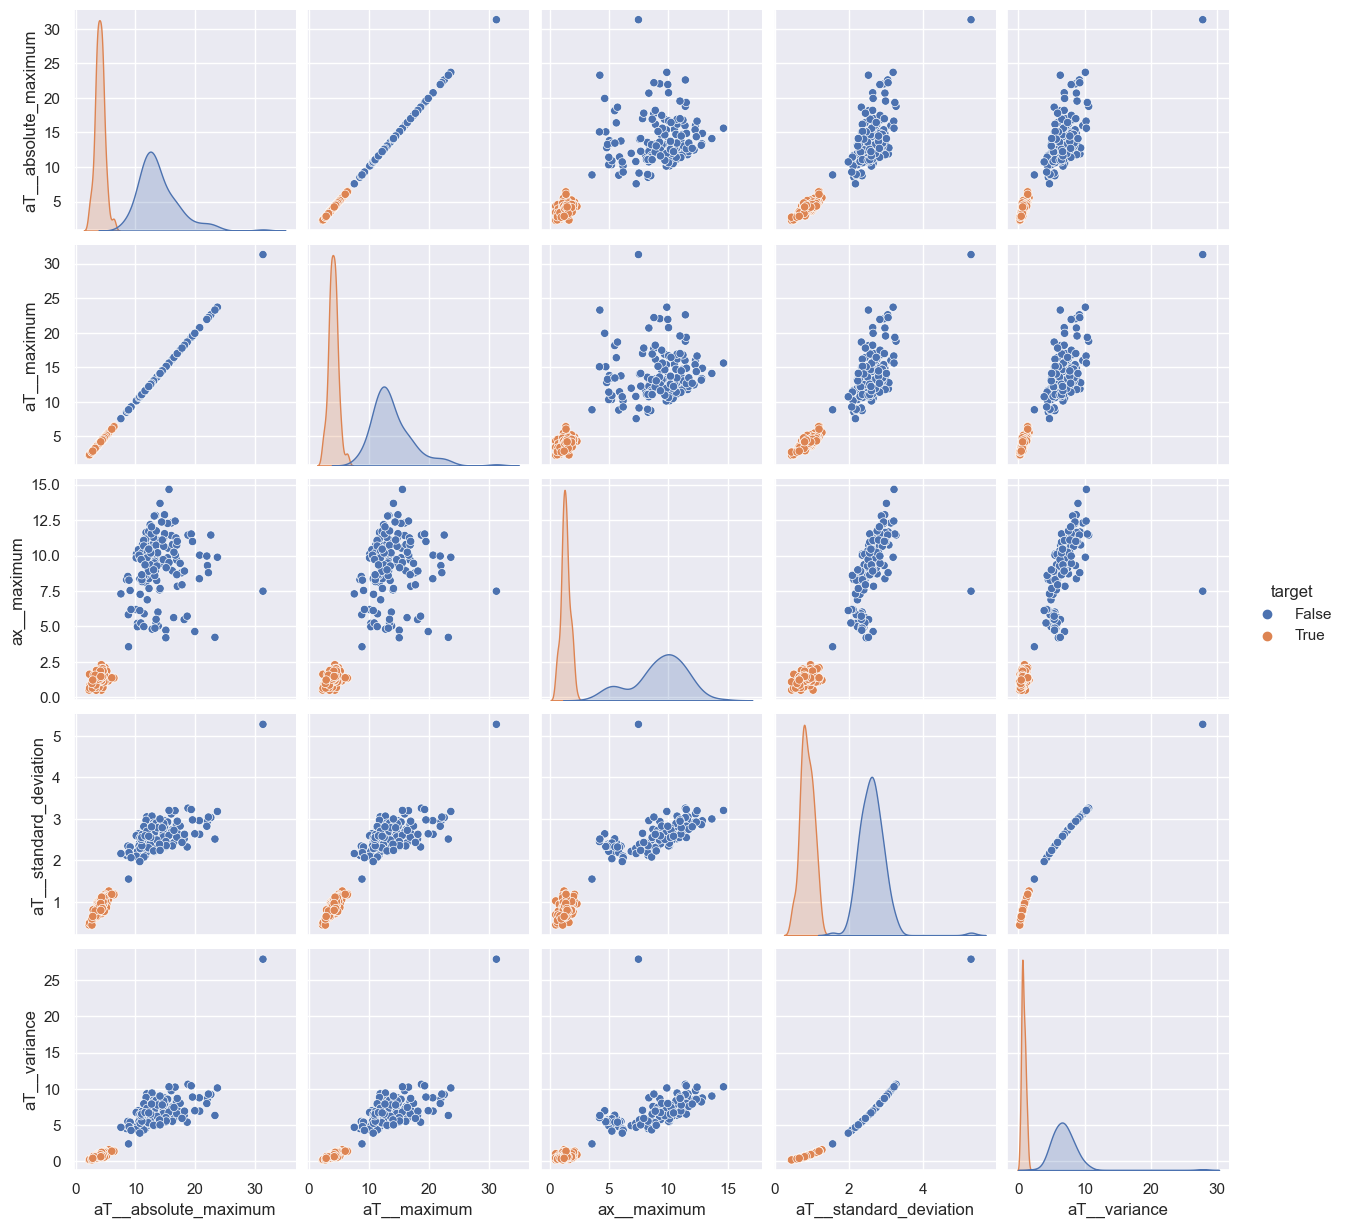

In [90]:
# Visualise these five features
Xselected["target"] = target
features.append("target")
sns.pairplot(Xselected[features], hue = "target")        

Based on the plot above, we observe that there is a clear separation of the True (walking) and False (running) values in the target vector. The plots on the leading diagonal indicate minimal overlap which will be useful for fitting a model and there is a distinct peak for each of the regions. The True points are clustered together quite well whilst the False ones are quite scattered and exhibit increased variance. This could be due the fact that running involved a lot more erratic and sudden movements. As a result, the maximum acceleration (x, z, and T) values for the False points are a lot higher.

In [91]:
# Set up RandomForestClassifier
rfc = RandomForestClassifier(random_state = 786)
features = features[:5]
rfc.fit(X[features[:5]], target)

RandomForestClassifier(random_state=786)

In [92]:
# Find area under curve of ROC plot
roc_auc_score(target, rfc.predict_proba(X[features])[:, 1])

1.0

In [93]:
candidates = pd.Series(rfc.feature_importances_[:], index = features).sort_values(ascending = False).head()

<Axes: xlabel='aT__standard_deviation', ylabel='Target'>

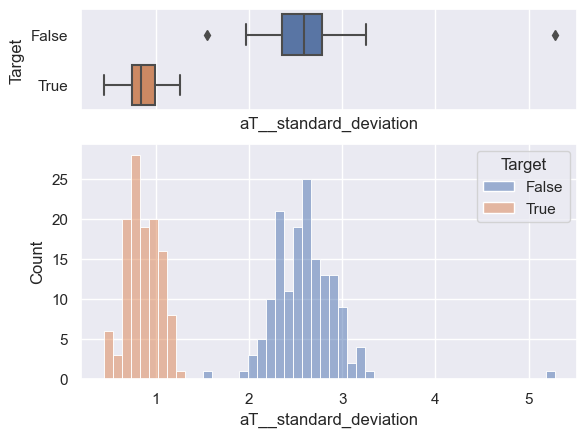

In [100]:
# Plot distribution of candidate features and target
X_dist = X.assign(Target = target.values)
phi_1 = candidates.index[0]
f1, (ax_box1, ax_hist1) = plt.subplots(2, sharex = True, gridspec_kw = {"height_ratios": (.30, .70)})
sns.histplot(x = phi_1, data = X_dist, hue = "Target", ax = ax_hist1, bins = 50)
sns.boxplot(x = phi_1, y = "Target", data = X_dist, orient = "h", ax = ax_box1)

<Axes: xlabel='aT__variance', ylabel='Target'>

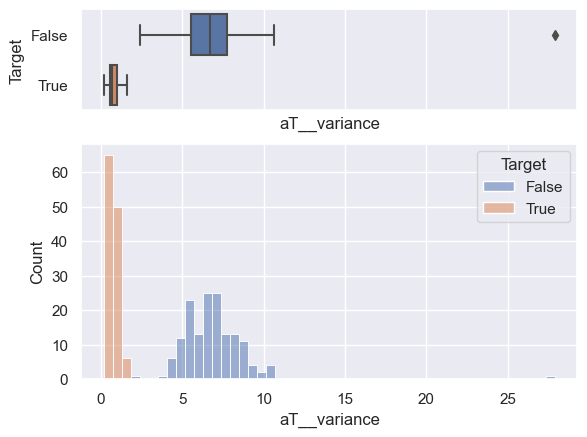

In [101]:
phi_2 = candidates.index[1]
f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.30, .70)})
sns.histplot(x = phi_2, data = X_dist, hue = "Target", ax=ax_hist2, bins = 50)
sns.boxplot(x = phi_2, y = "Target", data = X_dist, orient = "h", ax = ax_box2)

c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


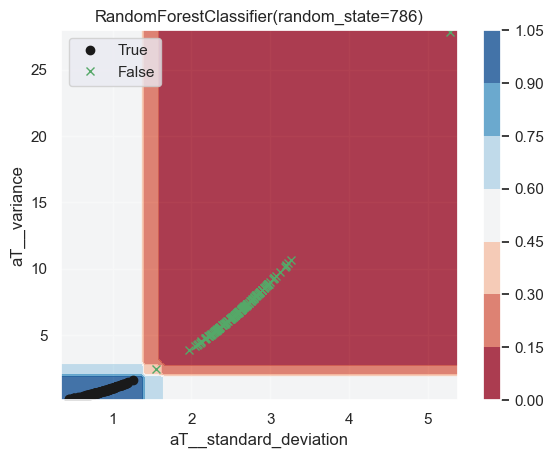

In [102]:
# Create function to plot output of model
def plot_decision_function(clf, X, x1, x2, y):
    x1grid = np.linspace(X[x1].min() - 0.1, X[x1].max() + 0.1, 100)
    x2grid = np.linspace(X[x2].min() - 0.1, X[x2].max() + 0.1, 100)
    clf.fit(X[[x1, x2]], target)
    xx, yy = np.meshgrid(x1grid, x2grid)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    zz = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, zz, cmap = plt.cm.RdBu, alpha = .8)
    plt.plot(X[x1][target], X[x2][target], 'ko', label = True)
    plt.plot(X[x1][~target], X[x2][~target], 'gx', label = False)
    plt.xlabel(x1)
    plt.ylabel(x2)
    plt.colorbar()
    plt.legend()
    plt.title(str(clf))
    
plot_decision_function(rfc, Xselected[features], phi_1, phi_2, target)

In [103]:
# Fit a random forest classifier
rfc.fit(Xselected[features], target)

# Evaluate performance using the most statistically significant features and 10 times repeated, 10-fold cross-validation
cv = RepeatedKFold(n_splits = 10, n_repeats = 10)
scores = cross_val_score(rfc, Xselected.iloc[:, :31], target, cv = cv)
print(np.mean(scores), np.std(scores))

0.9963888888888889 0.01083502903565144


The high accuracy is indicated by the clear separation of points in the pairs plot. The differences in the running and walking data were significant enough to allow the model to distinguish between the activities extremely well.

#### Potential Healthcare Usage
On average, most people's heart rate is a lot lower when they are walking compared to when they are running. If the model is used to predict the type of activity that an individual is performing (based on linear acceleration) and their pulse doesn't match the output, then this could be attributed to adverse health conditions. For example, if the individual's heart rate is measured at 140bpm and the model ajudges them to be walking then this raises concerns for respiratory problems. In reality though, the model may have misclassified the activity and thus returns a false positive. The individual will be treated for something they potentially might not have.

Conversely, if a patient is actually sick with a high pulse during walking but the model suggests they were running, then a false negative is returned and the individual isn't treated. Both situations aren't ideal but the latter has an extremely high cost of misclassification. It could lead to severe illness or even death due to a lack of treatment.

The decision model would be scrutinized in such cases and might not be used anymore. To improve the performance, it would be prudent to add penalties for misclassification. The objective would then be to minimise the total misclassification cost instead of accuracy.